# TP4_depart
## IFT870/BIN710 Hiver 2021

### Mathieu Lussier (LUSM1202)
### Gabriel Gibeau Sanchez (GIBG2501)

In [1]:
import sklearn
import numpy as np
import scipy as sp
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import  KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier


from itertools import product
from re import finditer
import warnings
warnings.filterwarnings("ignore")

# for printing variables in a markdown cell
from IPython.display import Markdown as md

#### Détails
Il est à noter que le fichier RNA.csv remit sur turnin est la version corrigée tel que demandé à la question 1).
Pour rouler le notebook sans problème, il est préférable de lire (à la cellule suivante) le fichier RNA.csv d'origine.

In [2]:
TP4_data_file = "RNA_original.csv"
TP4_data = pd.read_csv(TP4_data_file,index_col=0)
TP4_data.shape

(395, 2)

In [3]:
TP4_data[0:10]

,sequence,classe
id,,
AF093014.1/662-809,CACUUUAAGUAAUGGAUGUCUUGGUUCUCAUAACGAUGAAGGACGC...,RF00002
M14649.1/2015-2169,AACUUUCAGCGACGGAUGUCUCGGCUCGAACAACGAUGAAGGGCGC...,RF00002
X53361.2/1206-1368,ACCUGUUGUGGUGGAUGUCUUGGCCCAGGUUCUGAGGAAGGACACA...,RF00002
M86760.1/218-371,AACUUUCAGCAAUGGAUCUCUUGGUUCCCGCGUCGAUGAAGAACGU...,RF00002
X00601.1/3997-4154,AAGCAUAAACGGUGAAUACCUCGACUCCUAAAUCGAUGAAGACCGU...,RF00002
U48228.1/7-166,CAAUCUUAACGAUGGAUGUCUUGGUUCCUAUAGCGAUGAAGGCCGC...,RF00002
U58510.1/2022-2198,AACCCUAGUGAUGGAUGUCUAGGCUCCCGUAUCGAUGAAGAACGUA...,RF00002
AL049755.2/30863-31016,AACUUUCAGCAACGGAUCUCUUGGCUCUCGCAUCGAUGAAGAACGC...,RF00002
U13369.1/6624-6776,GACUCUUAGCGGUGGAUCACUCGGCUCGUGCGUCGAUGAAGAACGC...,RF00002


_______________________

# Q1
## a)
Un examen des données initiales revèle que les entrées dont la classes est absente contiennent en fait la classe dans la
colonne "sequence", concaténée à la valeur de séquence génétique mais séparée par une virgule. Puisque les champs du
fichier sont contenus entre des guillements doubles, mais que pour ces entrées un guillemet ouvrant au début de la séquence génétique ne trouve pas son homologue fermant (il devrait être à la fin de la séquence) ce qui fait en sorte que la virgule est vue comme un simple caractère de ponctuation, au lieu de servir de séparateur pour le format CSV.

Pour remédier à ce problème, nous utilisons les fonctions de la classe $\textit{string}$ et nous sauvegardons le
$\textit{DataFrame}$ corrigé dans un nouveau fichier CSV intitulé "RNA.csv".

In [4]:
# Get indexes for which the entries have no classe
na_indexes = TP4_data['classe'].isna()

data = TP4_data.copy()

# Get missing classes & cleaned sequences
split_vals = TP4_data.loc[na_indexes, 'sequence'].str.split(pat='[,"]', expand=True)
data.loc[na_indexes, 'classe'] = split_vals.iloc[:, 1]
data.loc[na_indexes, 'sequence'] = split_vals.iloc[:, 0]

# Save cleaned data
data.to_csv('RNA.csv')

# We'll free up unused variables to keep our dev space uncluttered
del split_vals
del na_indexes

## b)

Il y a 12 classes dont la répartition est donnée dans la cellule de code suivante:

In [5]:
# Ceckout unique classes values and instances number for each classe
print(f'Il y a {data.classe.unique().shape[0]} classes')
for ix, cls in enumerate(data.classe.value_counts().index):
    print(f'La classe {cls} contient {data.classe.value_counts()[ix]} entrées')

Il y a 12 classes
La classe RF00008 contient 54 entrées
La classe RF00004 contient 51 entrées
La classe RF00017 contient 49 entrées
La classe RF00002 contient 46 entrées
La classe RF00003 contient 42 entrées
La classe RF00023 contient 36 entrées
La classe RF00015 contient 25 entrées
La classe RF00024 contient 24 entrées
La classe RF00011 contient 19 entrées
La classe RF00012 contient 17 entrées
La classe RF00019 contient 16 entrées
La classe RF00025 contient 16 entrées


## c)

Ici nous balançons le nombre de données en se défaussant des instances excédant le nombre minimal

In [6]:
# Fint out the minimum instances number
classes_rep = data.classe.value_counts()
print(f'Le nombre minimum d\'instance d\'une classe est {classes_rep.min()} pour la classe:\n'
      f'{classes_rep[classes_rep == classes_rep.min()].index.values}')

cut_off = classes_rep.min()

# Trim off exceding instances
for cls in classes_rep.index:
    indexes_to_drop = data[data['classe'] == cls].index
    if indexes_to_drop.shape[0] > cut_off:
        data.drop(index=indexes_to_drop[16:], axis=0, inplace=True)

print(f'Après traitement, les classes contiennent maintenant {cut_off} instance chacune:')
for ix, cls in enumerate(data.classe.value_counts().index):
    print(f'La classe {cls} contient {data.classe.value_counts()[ix]} entrées')

del classes_rep
del cut_off

Le nombre minimum d'instance d'une classe est 16 pour la classe:
['RF00019' 'RF00025']
Après traitement, les classes contiennent maintenant 16 instance chacune:
La classe RF00011 contient 16 entrées
La classe RF00003 contient 16 entrées
La classe RF00017 contient 16 entrées
La classe RF00019 contient 16 entrées
La classe RF00012 contient 16 entrées
La classe RF00023 contient 16 entrées
La classe RF00008 contient 16 entrées
La classe RF00025 contient 16 entrées
La classe RF00024 contient 16 entrées
La classe RF00002 contient 16 entrées
La classe RF00004 contient 16 entrées
La classe RF00015 contient 16 entrées


______________

# Q2
## a)
Ici nous ajoutons une colonne à notre $\textit{dataframe}$ pour le nouvel attribut "longueur". Nous allons également encoder
les classes en format numérique pour pouvoir calculer aisément la justesse des prédictions faites par notre modèle de
$\textit{K-Nearest-Neighbors}$.

In [7]:
data

,sequence,classe
id,,
AF093014.1/662-809,CACUUUAAGUAAUGGAUGUCUUGGUUCUCAUAACGAUGAAGGACGC...,RF00002
M14649.1/2015-2169,AACUUUCAGCGACGGAUGUCUCGGCUCGAACAACGAUGAAGGGCGC...,RF00002
X53361.2/1206-1368,ACCUGUUGUGGUGGAUGUCUUGGCCCAGGUUCUGAGGAAGGACACA...,RF00002
M86760.1/218-371,AACUUUCAGCAAUGGAUCUCUUGGUUCCCGCGUCGAUGAAGAACGU...,RF00002
X00601.1/3997-4154,AAGCAUAAACGGUGAAUACCUCGACUCCUAAAUCGAUGAAGACCGU...,RF00002
...,...,...
"'U10566.1/72-260""",AGUUUCUCGAUAAUUGAUCUGUAGAAUCUGUCAAGCAAAACCCCAA...,RF00025
"'U10567.1/1-190""",AGCUGGUGGAAGUGCGUCAGUCAUAGCACUGUCAACAAAACCCCAA...,RF00025
"'U22351.1/82-237""",AUACCCGCAUUUUCAUUCAGAUCUUUAAUGGAGCUGUCAUUCAACC...,RF00025


In [8]:
# add longueur column
data['longueur'] = data['sequence'].str.len().values

# Encode classes labels to numerical values
lencoder = LabelEncoder()
data['encoded_classe'] = lencoder.fit_transform(data['classe'].values)

# Prepare training/test data, train and predict
# Bien que la distribution des classes soit uniforme, nous utilserons tout de même
# le paramèetre stratify pour assurer une présence équivalente dans les deux ensembles
X_train, X_test, y_train, y_test = train_test_split(data['longueur'].values,
                                                    data['encoded_classe'].values,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    shuffle=True,
                                                    stratify=data['encoded_classe'].values)

knn = KNeighborsClassifier()
knn.fit(X=X_train.reshape(-1, 1), y=y_train)

predictions = knn.predict(X=X_test.reshape(-1, 1))

# Get the indexes of the wrong predictions
wrong_indexes = predictions-y_test != 0

# Print predictions accuracy
print(f'Le score de prédiction est: {(y_test.shape[0] - wrong_indexes.sum())/y_test.shape[0]}')

# Get correct prediction to determine which classes are most easily predicted based on sequence length
right_preds = y_test[~wrong_indexes]

# Get the 5 most frequent classes that are rightfully predicted
print(pd.Series(right_preds).value_counts())
fclasses = lencoder.inverse_transform(pd.Series(right_preds).value_counts()[0:5].index)
print(f'Selon ce qu\'on constate, les classe les mieux prédites avec le modèle KNN basé sur la longueur de la séquence sont {fclasses}')

# lets drop the five most easily predicted classes
for cls in fclasses:
    data.drop(index=data[data['classe'] == cls].index, axis=0, inplace=True)

Le score de prédiction est: 0.7435897435897436
8     4
10    3
7     3
5     3
4     3
3     3
1     3
6     2
2     2
11    1
9     1
0     1
dtype: int64
Selon ce qu'on constate, les classe les mieux prédites avec le modèle KNN basé sur la longueur de la séquence sont ['RF00019' 'RF00024' 'RF00017' 'RF00012' 'RF00011']


## b) k-mers

Dans un premier temps, il nous faut trouver toutes les permutations, incluant les répétitions, des nucléotides de l'ARN:

In [9]:
nucleotides = ['A', 'C', 'G', 'U']
max_kmer_length = 4

kmer_lists = list()
# for each length of kmer...
for i in range(0, max_kmer_length):
    # Create all permutations of that length, and the list they will be stored in
    kmer = product(nucleotides, repeat=i+1)
    kmer_lists.append(list())
    l = kmer_lists[i]
    for k in kmer:
        # then store permutated values as string in a list
        w = ''
        for j in range(0, i+1):
            w += k[j]
        l.append(w)

for ix, l in enumerate(kmer_lists):
    print(f'Samples of {ix+1}-mer list')
    for p in random.sample(l, max_kmer_length):
        print(p)


Samples of 1-mer list
A
U
C
G
Samples of 2-mer list
UA
GC
AU
GG
Samples of 3-mer list
CGC
CUU
AUC
GCC
Samples of 4-mer list
GGAA
CACA
CGGC
GGCU


Nous allons ensuite créer 4 nouveaux $\textit{dataframes}$ pour faire le décompte du nombre d'occurence des k-mer dans
les séquence de nucléotides, et ultimement pouvoir comparer les 4 présentations.

In [10]:
def construct_kmer_list(data):
    # Lets start by copying our main dataframe in 4 new dataframes, drop the columns we won't need and put them in a list
    df_list = list()
    for i in range(0, max_kmer_length):
        df_list.append(data.copy())
        df_list[i].drop(labels=['longueur'], inplace=True, axis=1)
        # then lets add the needed columns in each new dataframe
        for km in kmer_lists[i]:
            df_list[i][km] = pd.Series(range(0, df_list[0].shape[0]))
            
    # Count the occurence of every k-mer for every sequence
    for df, kmlist in zip(df_list, kmer_lists):
        for km in kmlist:
            count = 0
            for ix, row in df.iterrows():
                # Here we use re.finditer() fct to get all k-mer occurence in a sequence
                count = sum(1 for _ in finditer(km, row['sequence']))
                df.loc[ix, km] = count

    return df_list
    

In [11]:
df_list = construct_kmer_list(data)

In [12]:
print('Lets show some k-mer counting samples...')
for df in df_list:
    print(df.loc[:, df.columns != 'sequence'].head())

Lets show some k-mer counting samples...
                     classe  encoded_classe     A     C     G     U
id                                                                 
AF093014.1/662-809  RF00002               0  51.0  26.0  26.0  45.0
M14649.1/2015-2169  RF00002               0  42.0  34.0  42.0  37.0
X53361.2/1206-1368  RF00002               0  33.0  42.0  52.0  36.0
M86760.1/218-371    RF00002               0  39.0  31.0  38.0  46.0
X00601.1/3997-4154  RF00002               0  47.0  29.0  40.0  42.0
                     classe  encoded_classe    AA    AC    AG    AU    CA  \
id                                                                          
AF093014.1/662-809  RF00002               0  14.0   8.0   9.0  18.0  13.0   
M14649.1/2015-2169  RF00002               0  13.0   8.0   8.0  12.0   8.0   
X53361.2/1206-1368  RF00002               0   6.0   9.0  13.0   4.0  11.0   
M86760.1/218-371    RF00002               0  11.0   4.0   9.0  13.0  10.0   
X00601.1/3997-4154  R

Comme on devait s'y attendre, on voit que les fréquences des k-mer est inversement prortionnelle à leurs longueurs.

Une fois le décompte fait, il ne reste qu'à créer les modèles de classification que l'on souhaite tester. Le compte
de kmers nous donnes des vecteurs $v$ tels que $v \in \mathbb{N_0^{n}},\, n=4,16,64,256$. Dans un premier temps, nous
évaluerons la qualité du clustering à l'aide des méthodes quantitatives, puis nous vérifirons la distribution des valeurs
pour chaque dimension et pour chaque table de k-mer pour voir si les méthodes faisant l'hypothèse gaussienne devraient être
utilisées.

#### Visualisation T-SNE

Text(0.5, 1.0, 'T-SNE (4-mer)')

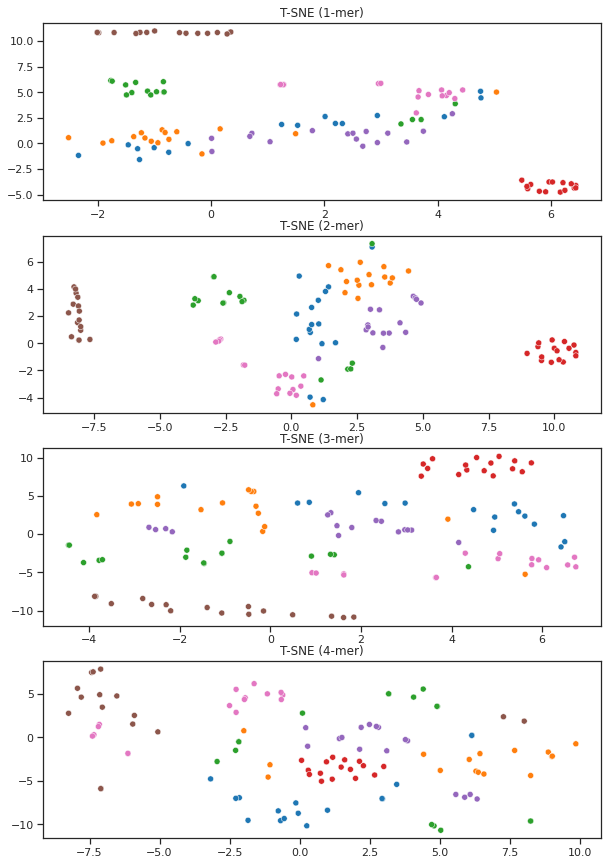

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE()
X_tsne_pca_1mer = tsne.fit_transform(df_list[0].loc[:, kmer_lists[0]].values)
X_tsne_pca_2mer = tsne.fit_transform(df_list[1].loc[:, kmer_lists[1]].values)
X_tsne_pca_3mer = tsne.fit_transform(df_list[2].loc[:, kmer_lists[2]].values)
X_tsne_pca_4mer = tsne.fit_transform(df_list[3].loc[:, kmer_lists[3]].values)

fig, axes = plt.subplots(4, 1, figsize=(10,15))
sns.scatterplot(x=X_tsne_pca_1mer[:,0], y=X_tsne_pca_1mer[:,1], hue=qq['encoded_classe'], palette='tab10', ax=axes[0], legend=False)
sns.scatterplot(x=X_tsne_pca_2mer[:,0], y=X_tsne_pca_2mer[:,1], hue=qq['encoded_classe'], palette='tab10', ax=axes[1], legend=False)
sns.scatterplot(x=X_tsne_pca_3mer[:,0], y=X_tsne_pca_3mer[:,1], hue=qq['encoded_classe'], palette='tab10', ax=axes[2], legend=False)
sns.scatterplot(x=X_tsne_pca_4mer[:,0], y=X_tsne_pca_4mer[:,1], hue=qq['encoded_classe'], palette='tab10', ax=axes[3], legend=False)
axes[0].set_title('T-SNE (1-mer)')
axes[1].set_title('T-SNE (2-mer)')
axes[2].set_title('T-SNE (3-mer)')
axes[3].set_title('T-SNE (4-mer)')


### Commentaires

Tel que nous pouvons constater par les visualisations T-SNE, il y a certe distinction des classes, mais leurs regroupements n'est pas nécessairement franc et linéaire. De ce fait, des modèles permettant de traiter des relations non linéaires sont à favoriser.
Afin de confirmer nos hypothèses nous avons décidé d'utiliser ces modèles:

* SVC()
* KNeighbors()
* DecisionTree()
* RandomForest() de base
* RandomForest() criterion='gini' max_depth=10
* MLPClassifier()

Nous nous attendons à de bon résultat provenant des modèles SVC(), MLPClassifier() ainsi que les RandomForest() de par leur méthode d'ensemble.



In [34]:
model_dict = {'1-mer': [], '2-mer': [], '3-mer': [], '4-mer': []}

for df, km in zip(df_list, kmer_lists):

    # Create our models
    models = list()
    models.append(("SVC",SVC()))
    models.append(("KNeighbors", KNeighborsClassifier()))
    models.append(("DecisionTree", DecisionTreeClassifier()))
    models.append(("RandomForest", RandomForestClassifier()))
    rf2 = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=10, random_state=0, max_features=None)
    models.append(("RandomForest2", rf2))
    models.append(("MLPClassifier", MLPClassifier(solver='lbfgs', random_state=0, max_iter=500)))

    results = list()
    names = list()
    

    # Train and test them using cross-validation
    for name, model in models:
        result = cross_val_score(model, df.loc[:, km], df['encoded_classe'],  cv=5)
        names.append(name)
        results.append(result)

    print(f'\nLes résultats de chaque modèle pour {int(np.log2(len(km))/np.log2(4))}-mer sont:')
    model_dict[f'{int(np.log2(len(km))/np.log2(4))}-mer'] = models
    for i in range(len(names)):
        print(f'{names[i]} {results[i].mean()}')


Les résultats de chaque modèle pour 1-mer sont:
SVC 0.7600790513833993
KNeighbors 0.8407114624505929
DecisionTree 0.7770750988142293
RandomForest 0.8407114624505929
RandomForest2 0.8494071146245059
MLPClassifier 0.6434782608695653

Les résultats de chaque modèle pour 2-mer sont:
SVC 0.8932806324110671
KNeighbors 0.8845849802371542
DecisionTree 0.8130434782608695
RandomForest 0.8944664031620553
RandomForest2 0.8857707509881422
MLPClassifier 0.7687747035573123

Les résultats de chaque modèle pour 3-mer sont:
SVC 0.9474308300395258
KNeighbors 0.9296442687747035
DecisionTree 0.6782608695652173
RandomForest 0.9470355731225297
RandomForest2 0.866798418972332
MLPClassifier 0.9019762845849802

Les résultats de chaque modèle pour 4-mer sont:
SVC 0.9735177865612649
KNeighbors 0.7869565217391304
DecisionTree 0.7600790513833993
RandomForest 0.9648221343873518
RandomForest2 0.9027667984189722
MLPClassifier 0.9284584980237154


### Commentaires

Tel qu'expliqué plus haut, nous avons effectivement des métriques élevées pour les modèles SVC(), MLPClassifier() ainsi que les RandomForest().

Après analyse des résultats, nous constatons que la représentation 4-mer permet une meilleure prédiction à l'aide des modèles convenable aux relations non-linéaires.
Finalement, le modèle SVC() est le plus performant avec une prédiction de 97.35%. 




______________

# Q3
## a)
Nous allons générer des données bruitées afin de tester la robustesse des prédictions au bruit. Pour ce faire, nous constuirons un jeu de données mélangées de même dimension que les données originales. De plus, pour chaque donné x, nous utiliserons les mêmes ARN, mais dans un ordre différent. La catégorie "BRUIT" leur sera attribuée.

In [30]:
data_noise = data.copy()

data_noise['sequence'] = data_noise['sequence'].apply(lambda x: ''.join(random.sample(x, len(x))))
data_noise['classe'] = 'BRUIT'
data_noise['encoded_classe'] = data['encoded_classe'].max() + 1

df_noise_list = construct_kmer_list(data_noise)

## b) Ajout de bruits

Utilisant le modèle choisi à la précédente question, le score de classification sera recalculé mais en incluant un pourcentage de bruit.

Erratum: le modèle choisi doit être testé avec chacune des représentations 1-mer, 2-mer, 3-mer, 4-mer et l'ajout de bruit.

In [39]:
percentage = [0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 1]

for i in range(4):
    df_noise = df_noise_list[i]
    df_length = df_noise.shape[0]
    
    df = df_list[i]
    km = kmer_lists[i]
    print(f"Représentation {i+1}-mer:")
    print("")
    for perc in percentage:
        model_optimal = SVC()  # modèle choisi de la question précédente

        idx = np.random.choice(np.arange(df_noise.shape[0]), int(perc * df_length))
        df_with_noise = pd.concat([df, df_noise.iloc[idx]])

        result = cross_val_score(model_optimal, df_with_noise.loc[:, km], df_with_noise['encoded_classe'],  cv=5)
        print(f'{int(perc*100)}% noise: {result.mean()}')

    print("-------------------------------------")

Représentation 1-mer:

5% noise: 0.7105072463768115
10% noise: 0.6916666666666667
20% noise: 0.6341880341880342
40% noise: 0.4616935483870968
60% noise: 0.45285714285714285
80% noise: 0.45792682926829265
100% noise: 0.48666666666666664
-------------------------------------
Représentation 2-mer:

5% noise: 0.855072463768116
10% noise: 0.8136666666666666
20% noise: 0.7837606837606839
40% noise: 0.6346774193548386
60% noise: 0.5863492063492063
80% noise: 0.5915853658536585
100% noise: 0.5668686868686869
-------------------------------------
Représentation 3-mer:

5% noise: 0.9068840579710145
10% noise: 0.8623333333333333
20% noise: 0.8358974358974359
40% noise: 0.827016129032258
60% noise: 0.7823809523809524
80% noise: 0.8164634146341463
100% noise: 0.8347474747474747
-------------------------------------
Représentation 4-mer:

5% noise: 0.9318840579710145
10% noise: 0.9106666666666667
20% noise: 0.8065527065527066
40% noise: 0.8340725806451612
60% noise: 0.8382539682539683
80% noise: 0.8

## c)

#### Commentaires

Tel que présenté à la question précédente, parmi les 4 représentations, celle associée à 4-mer permet d'avoir le plus haut résultat. Ceci peut notamment être attribué à la réduction de répétition d'information considérant qu'un 4-mer est beaucoup moins fréquent qu'un 1- ou 2-mer. 

De plus, sans grande surprise, la performance diminue au fur et à mesure que le bruit est ajouté. La meilleure performance est obtenue avec l'ajout de 5% de bruit. Il est intéressant de constater qu'après 40% d'ajout de bruit, le modèle semble se stabiliser et même s'améliorer démontrant qu'il aurait possiblement détecté l'injection de bruit.


